# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
  
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>

## <center>Projeto Final</center>

**Nome**: Anne Mari Suenaga Sakai
**RA**: 822304

**Nome**: Felipe Jun Nishitani
**RA**: 822353


---
## Imports e configuração inicial

Carregamos os módulos necessários, incluindo os scripts do projeto.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.preprocessamento import *
from scripts.analise_exploratoria import *
from scripts.experimentos import *
from scripts.analise_resultados import *

---
### Análise exploratória

Nesta seção, deve ser feita a leitura da base de dados e todas as análises necessárias para interpretar e analisar os dados, tais como:
* Significado de cada atributo
* Medidas descritivas
* Gráficos

A base contém atributos derivados de sensores vestíveis, representando médias, desvios padrão, máximos e mínimos das medições fisiológicas de cada usuário.  
A variável **classe** indica o tipo de esforço (Stress, Aeróbico ou Anaeróbico).

- Os boxplots revelam a presença de outliers em alguns atributos, sugerindo variações extremas entre sujeitos.  
- A matriz de correlação mostra que certos sensores apresentam relações lineares, indicando possíveis atributos redundantes.  
- As distribuições das classes mostram um conjunto relativamente balanceado entre as categorias.


In [11]:
base_path = "dataset"
df = carregar_e_resumir(base_path)


--- Carregando dataset ---

--- Gerando dataset consolidado (TREINO) ---
Treino consolidado: 75 amostras, 26 atributos.

✅ Primeiras linhas do dataset:


,Id,classe,TEMP_mean,TEMP_std,TEMP_max,TEMP_min,HR_mean,HR_std,HR_max,HR_min,...,IBI_max,IBI_min,EDA_mean,EDA_std,EDA_max,EDA_min,BVP_mean,BVP_std,BVP_max,BVP_min
0,U_79201,STRESS,34.270396,0.650459,34.91,4.0,98.821344,12.904438,126.50,1.0,...,1607.984375,0.437500,2.189811,0.514347,4.000000,0.0,0.020494,81.571663,859.42,-875.69
1,U_56491,ANAEROBIC,28.349428,0.684538,29.17,4.0,88.201980,19.968626,140.27,1.0,...,1894.265625,0.359375,0.695010,0.666676,4.000000,0.0,0.021553,65.304643,540.11,-626.35
2,U_94628,ANAEROBIC,33.942008,0.573440,35.03,4.0,105.932371,19.999631,146.28,1.0,...,2381.921875,0.359375,4.049409,3.069612,9.412058,0.0,0.009702,63.464990,628.35,-727.50
3,U_97819,AEROBIC,30.956354,0.788951,32.50,4.0,84.796326,11.187747,137.75,1.0,...,2496.375000,0.312500,5.359092,5.371851,20.911053,0.0,0.029392,74.716606,617.35,-935.50
4,U_96956,STRESS,31.656112,0.434754,32.45,4.0,79.560809,6.385105,96.42,1.0,...,3083.984375,0.500000,0.670497,0.493055,4.000000,0.0,0.001560,41.694090,1000.38,-1336.85



📊 Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         75 non-null     object 
 1   classe     75 non-null     object 
 2   TEMP_mean  75 non-null     float64
 3   TEMP_std   75 non-null     float64
 4   TEMP_max   75 non-null     float64
 5   TEMP_min   75 non-null     float64
 6   HR_mean    75 non-null     float64
 7   HR_std     75 non-null     float64
 8   HR_max     75 non-null     float64
 9   HR_min     75 non-null     float64
 10  ACC_mean   75 non-null     float64
 11  ACC_std    75 non-null     float64
 12  ACC_max    75 non-null     float64
 13  ACC_min    75 non-null     float64
 14  IBI_mean   74 non-null     float64
 15  IBI_std    73 non-null     float64
 16  IBI_max    74 non-null     float64
 17  IBI_min    74 non-null     float64
 18  EDA_mean   75 non-null     float64
 19  EDA_std    75 non-null     fl

,Id,classe,TEMP_mean,TEMP_std,TEMP_max,TEMP_min,HR_mean,HR_std,HR_max,HR_min,...,IBI_max,IBI_min,EDA_mean,EDA_std,EDA_max,EDA_min,BVP_mean,BVP_std,BVP_max,BVP_min
count,75,75,75.000000,75.000000,75.000000,75.0,75.000000,75.000000,75.000000,75.000000,...,7.400000e+01,74.000000,75.000000,75.000000,75.000000,75.0,75.000000,75.000000,75.000000,75.000000
unique,75,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,U_50642,ANAEROBIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,38.686697,3.366032,44.044267,4.0,94.025314,18.579690,146.385600,0.987733,...,2.276579e+07,0.623733,6.680819,3.824271,15.216182,0.0,0.003332,63.152524,688.064800,-794.003200
std,NaN,NaN,30.820055,12.813244,44.422771,0.0,16.048698,14.905988,101.353355,0.106232,...,1.958228e+08,1.974022,8.233190,4.143015,14.332138,0.0,0.011656,23.394932,285.728365,325.021499
min,NaN,NaN,25.293655,0.336072,26.510000,4.0,62.193177,4.845031,89.980000,0.080000,...,4.104688e+01,0.312500,0.238126,0.056464,4.000000,0.0,-0.032294,16.877194,105.410000,-2275.110000
25%,NaN,NaN,31.578436,0.508259,32.805000,4.0,82.338899,10.433353,118.015000,1.000000,...,1.222332e+03,0.328125,1.361458,0.918916,4.002110,0.0,-0.002810,48.690349,513.510000,-910.105000
50%,NaN,NaN,32.555787,0.684538,33.810000,4.0,93.919418,16.320087,136.970000,1.000000,...,1.829812e+03,0.367188,3.690940,2.595857,10.429475,0.0,0.003114,59.210829,628.420000,-708.800000
75%,NaN,NaN,33.672345,1.002177,34.875000,4.0,105.284238,21.652411,150.975000,1.000000,...,2.413855e+03,0.480469,8.649052,4.992074,20.089035,0.0,0.009903,75.079735,828.455000,-551.040000



--- Medidas Descritivas ---

📦 Distribuição das classes:


ANAEROBIC    28
STRESS       25
AEROBIC      22
Name: classe, dtype: int64

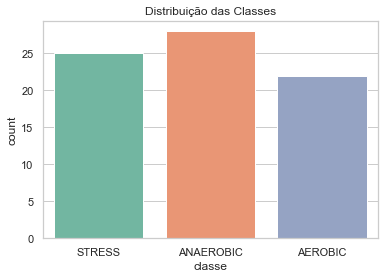


🚨 Valores ausentes por coluna:


Id           0
classe       0
TEMP_mean    0
TEMP_std     0
TEMP_max     0
TEMP_min     0
HR_mean      0
HR_std       0
HR_max       0
HR_min       0
ACC_mean     0
ACC_std      0
ACC_max      0
ACC_min      0
IBI_mean     1
IBI_std      2
IBI_max      1
IBI_min      1
EDA_mean     0
EDA_std      0
EDA_max      0
EDA_min      0
BVP_mean     0
BVP_std      0
BVP_max      0
BVP_min      0
dtype: int64

In [12]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Medidas descritivas
# ==========================================================
medidas_descritivas(df)


--- Boxplots e Histogramas ---


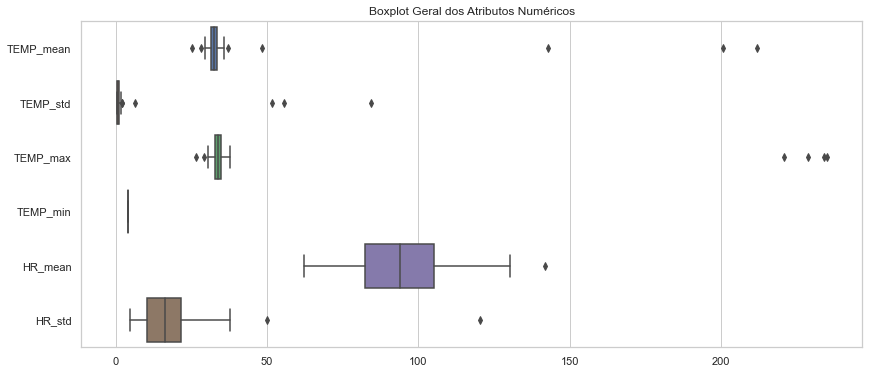

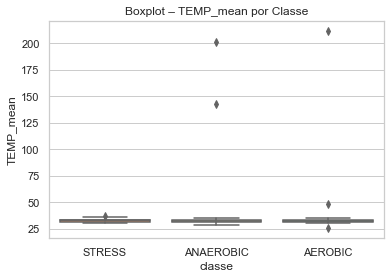

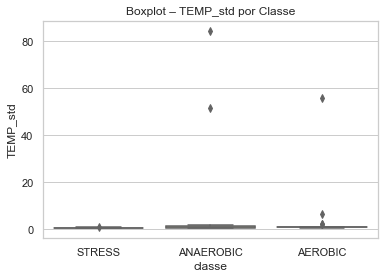

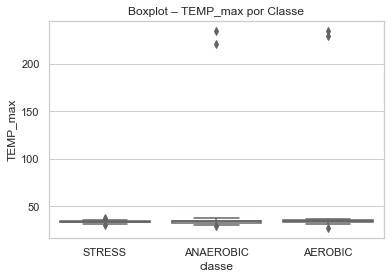

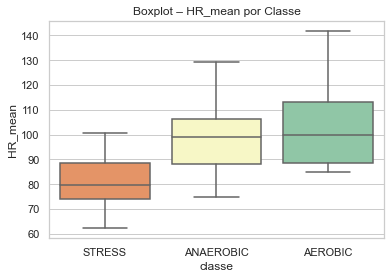

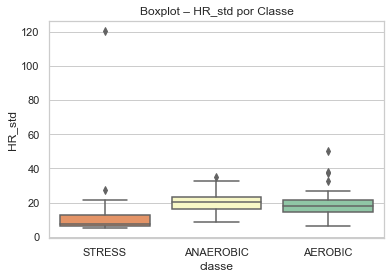

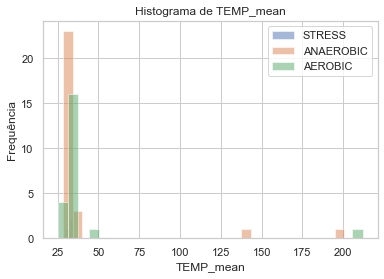

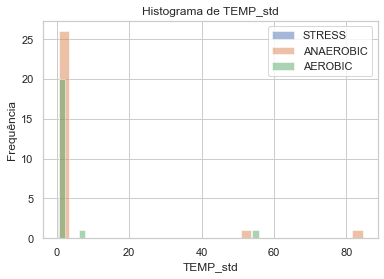

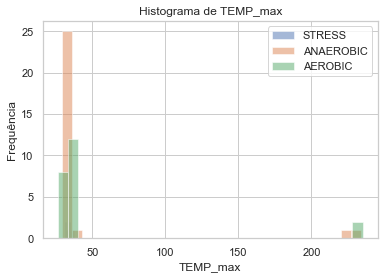

⚠️ Coluna TEMP_min ignorada (variância zero).


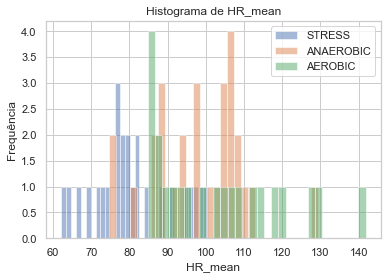

In [13]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Boxplots e Histogramas
# ==========================================================
from scripts.analise_exploratoria import boxplots_e_histogramas
boxplots_e_histogramas(df)


--- Matriz de Correlação ---


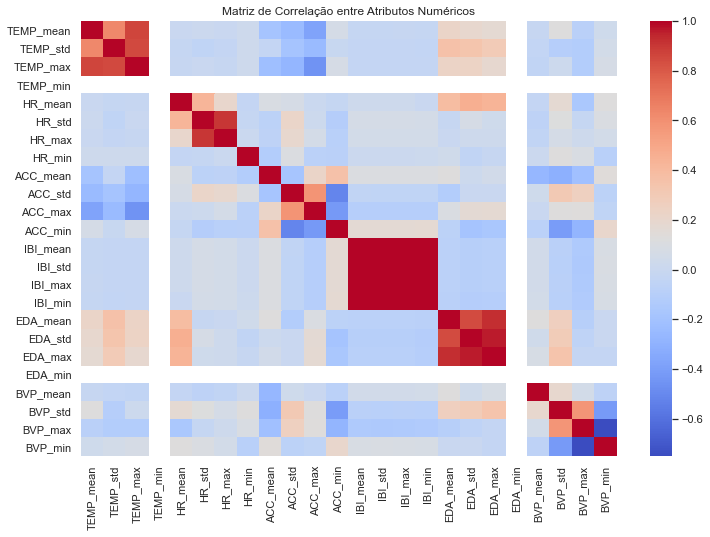


🔗 Maiores correlações:


IBI_std    IBI_max     1.000000
IBI_mean   IBI_std     0.999995
           IBI_max     0.999995
           IBI_min     0.999042
IBI_std    IBI_min     0.999042
IBI_max    IBI_min     0.999041
EDA_std    EDA_max     0.962325
EDA_mean   EDA_max     0.927488
HR_std     HR_max      0.906582
TEMP_mean  TEMP_max    0.868734
dtype: float64

In [14]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Correlação entre atributos
# ==========================================================
correlacao_atributos(df)



--- Pairplot Amostrado ---
Gerando pairplot com 75 amostras e 5 atributos...


/Users/annesakai/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/annesakai/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/annesakai/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


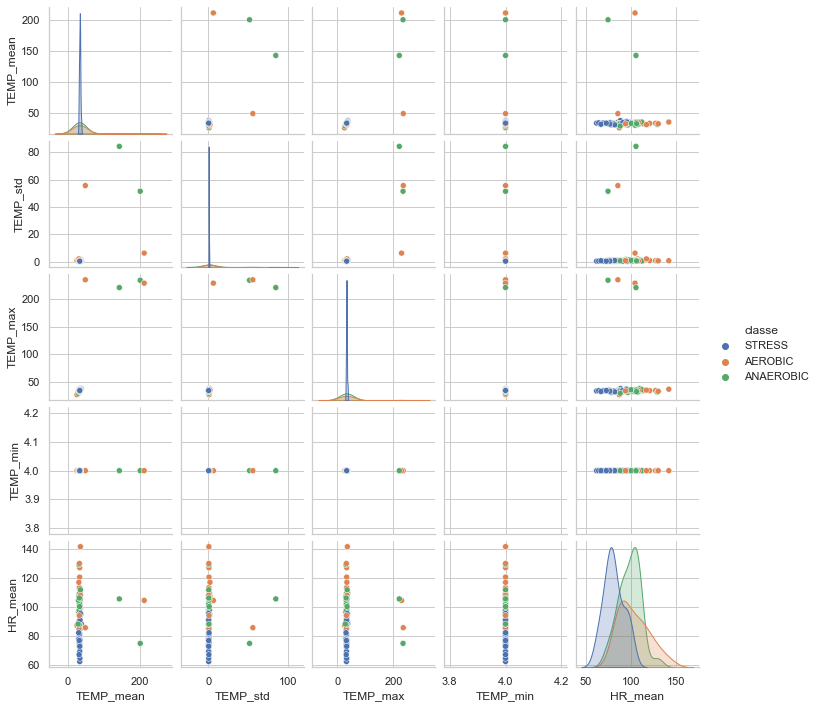

In [15]:
# ==========================================================
# ANÁLISE EXPLORATÓRIA - Pairplot amostrado
# ==========================================================
pairplot_amostrado(df)


---
### Pré-processamento

Nesta seção, as funções da etapa de pré-processamento dos dados devem ser implementadas e aplicadas (se necessário).

In [16]:
# ==========================================================
# PRÉ-PROCESSAMENTO - Tratamento de faltantes e outliers
# ==========================================================
df_limpo = tratar_valores_ausentes(df)
df_limpo = remover_outliers(df_limpo)
df_limpo.head()


--- Tratando valores ausentes ---

--- Removendo outliers (Z-score) ---
Removidas 6 amostras.


/Users/annesakai/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


,Id,classe,TEMP_mean,TEMP_std,TEMP_max,TEMP_min,HR_mean,HR_std,HR_max,HR_min,...,IBI_max,IBI_min,EDA_mean,EDA_std,EDA_max,EDA_min,BVP_mean,BVP_std,BVP_max,BVP_min
0,U_79201,STRESS,34.270396,0.650459,34.91,4.0,98.821344,12.904438,126.50,1.0,...,1607.984375,0.437500,2.189811,0.514347,4.000000,0.0,0.020494,81.571663,859.42,-875.69
1,U_56491,ANAEROBIC,28.349428,0.684538,29.17,4.0,88.201980,19.968626,140.27,1.0,...,1894.265625,0.359375,0.695010,0.666676,4.000000,0.0,0.021553,65.304643,540.11,-626.35
2,U_94628,ANAEROBIC,33.942008,0.573440,35.03,4.0,105.932371,19.999631,146.28,1.0,...,2381.921875,0.359375,4.049409,3.069612,9.412058,0.0,0.009702,63.464990,628.35,-727.50
3,U_97819,AEROBIC,30.956354,0.788951,32.50,4.0,84.796326,11.187747,137.75,1.0,...,2496.375000,0.312500,5.359092,5.371851,20.911053,0.0,0.029392,74.716606,617.35,-935.50
4,U_96956,STRESS,31.656112,0.434754,32.45,4.0,79.560809,6.385105,96.42,1.0,...,3083.984375,0.500000,0.670497,0.493055,4.000000,0.0,0.001560,41.694090,1000.38,-1336.85


In [17]:
# ==========================================================
# PRÉ-PROCESSAMENTO - Mais transformações
# ==========================================================

# TESTAR COM E SEM
remover_variancia_zero(df)
ajustar_skew(df)


--- Removendo atributos com variância zero ---
Removidos 2 atributos sem variância: ['TEMP_min', 'EDA_min']

--- Corrigindo skew em atributos assimétricos ---
Transformados: ['TEMP_mean', 'TEMP_std', 'TEMP_max', 'HR_std', 'HR_max', 'HR_min', 'ACC_max', 'ACC_min', 'IBI_mean', 'IBI_std', 'IBI_max', 'IBI_min', 'EDA_mean', 'EDA_std', 'EDA_max', 'BVP_max', 'BVP_min']


,Id,classe,TEMP_mean,TEMP_std,TEMP_max,TEMP_min,HR_mean,HR_std,HR_max,HR_min,...,IBI_max,IBI_min,EDA_mean,EDA_std,EDA_max,EDA_min,BVP_mean,BVP_std,BVP_max,BVP_min
0,U_79201,STRESS,2.395779,0.839145,2.341806,4.0,98.821344,2.308508,3.651178,1.071584,...,7.358154,0.753772,1.374142,0.899301,0.693147,0.0,0.020494,81.571663,6.628055,7.245241
1,U_56491,ANAEROBIC,1.620531,0.853762,1.539015,4.0,88.201980,2.840457,3.956805,1.071584,...,7.525758,0.716314,0.898894,0.959431,0.693147,0.0,0.021553,65.304643,6.079246,7.408991
2,U_94628,ANAEROBIC,2.365405,0.805300,2.353278,4.0,105.932371,2.842266,4.065602,1.071584,...,7.759134,0.716314,1.759801,1.612064,2.003108,0.0,0.009702,63.464990,6.263284,7.345759
3,U_97819,AEROBIC,2.036364,0.897263,2.078191,4.0,84.796326,2.121389,3.907412,1.071584,...,7.806830,0.693147,1.963043,1.989980,2.939747,0.0,0.029392,74.716606,6.242107,7.201626
4,U_96956,STRESS,2.123752,0.741310,2.071913,4.0,79.560809,1.264148,2.132982,1.071584,...,8.021236,0.782759,0.888867,0.890600,0.693147,0.0,0.001560,41.694090,6.799022,6.846156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,U_90561,STRESS,2.440957,0.724729,2.390596,4.0,95.507894,4.767753,6.797159,1.071584,...,7.620199,0.803962,1.601949,1.468933,2.152152,0.0,-0.000862,66.425865,6.461687,7.403530
71,U_83638,AEROBIC,2.152505,0.836701,2.111425,4.0,130.194755,3.856582,4.695651,1.071584,...,7.686456,0.693147,1.824584,1.790213,2.210632,0.0,0.000560,60.216307,6.259696,7.372156
72,U_16259,AEROBIC,2.140391,0.930217,2.223542,4.0,94.471348,2.426158,4.165424,1.071584,...,0.693147,0.723919,1.278259,1.425715,1.664144,0.0,0.000501,16.877194,0.693147,7.667734
73,U_17116,ANAEROBIC,2.272216,0.994944,2.314514,4.0,106.162911,2.932679,4.010963,1.071584,...,7.225265,0.693147,1.251218,1.133463,0.695255,0.0,0.004648,68.738971,6.458981,7.415699


In [19]:
# ==========================================================
# PRÉ-PROCESSAMENTO - Carregar os dados de teste e tratar igual ao treino
# ==========================================================
df_test = gerar_dataset_teste(base_path)
df_test = tratar_valores_ausentes(df_test)


--- Gerando dataset de TESTE ---
Teste consolidado: 25 amostras, 25 atributos.

--- Tratando valores ausentes ---


In [20]:
# ==========================================================
# PRÉ-PROCESSAMENTO - Preparar dados para os modelos
# ==========================================================
X_train, y_train, X_test, test_ids, label_encoder, scaler = preparar_dados(df_limpo, df_test)
X_train.shape, X_test.shape


--- Preparando dados de treino e teste ---
Treino shape final: (69, 24)
Teste shape final : (25, 24)


((69, 24), (25, 24))

---
### Experimento

Nesta seção, o experimento deve ser conduzido, utilizando os protocolos experimentais padrões e testando diferentes modelos.

Treinamos os seguintes modelos:
- KNN  
- Naive Bayes  
- Regressão Logística  
- Rede Neural (MLP)  
- SVM  


In [21]:
# ==========================================================
# EXPERIMENTOS - Treinamento de cada modelo
# ==========================================================
model_knn = treinar_knn(X_train, y_train)
model_nb = treinar_naive_bayes(X_train, y_train)
model_lr = treinar_regressao_logistica(X_train, y_train)
model_mlp = treinar_rede_neural(X_train, y_train)
model_svm = treinar_svm(X_train, y_train)

modelos = {
    "KNN": model_knn,
    "Naive Bayes": model_nb,
    "Regressão Logística": model_lr,
    "MLP": model_mlp,
    "SVM": model_svm
}


--- Treinando KNN (k=7) ---

--- Treinando Naive Bayes (Gaussian) ---

--- Treinando Regressão Logística ---

--- Treinando Rede Neural (MLP) ---

--- Treinando SVM (RBF) ---


In [ ]:
# Ajuste de hiperparâmetros com validação cruzada!!! 

---
### Análise dos Resultados

Nesta seção, os resultados devem ser exibidos através de tabelas e gráficos, comparados e profundamente analisados.

Para comparamos o desempenho dos modelos usamos:
- Métricas macro  
- Matriz de confusão  
- Curvas de aprendizado  
- Teste de McNemar para significância estatística  


In [23]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Comparar modelos
# ==========================================================
df_metrics = avaliar_modelos_dict(modelos, X_train, y_train)
df_metrics

,accuracy,precision_macro,recall_macro,f1_macro
modelo,,,,
KNN,0.724638,0.722019,0.708558,0.711453
Naive Bayes,0.797101,0.869096,0.754386,0.729722
Regressão Logística,0.942029,0.939271,0.939271,0.939271
MLP,1.000000,1.000000,1.000000,1.000000
SVM,0.913043,0.927249,0.899460,0.905196


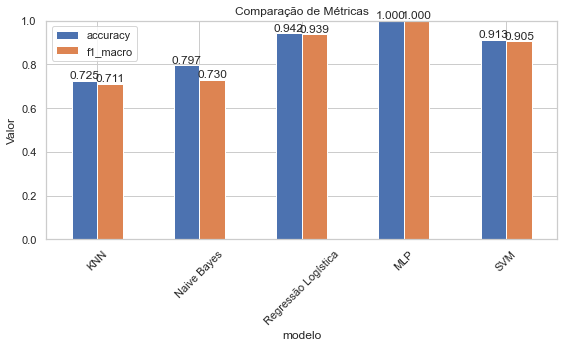

In [24]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Gráfico comparativo
# ==========================================================
plot_metric_bars(df_metrics)

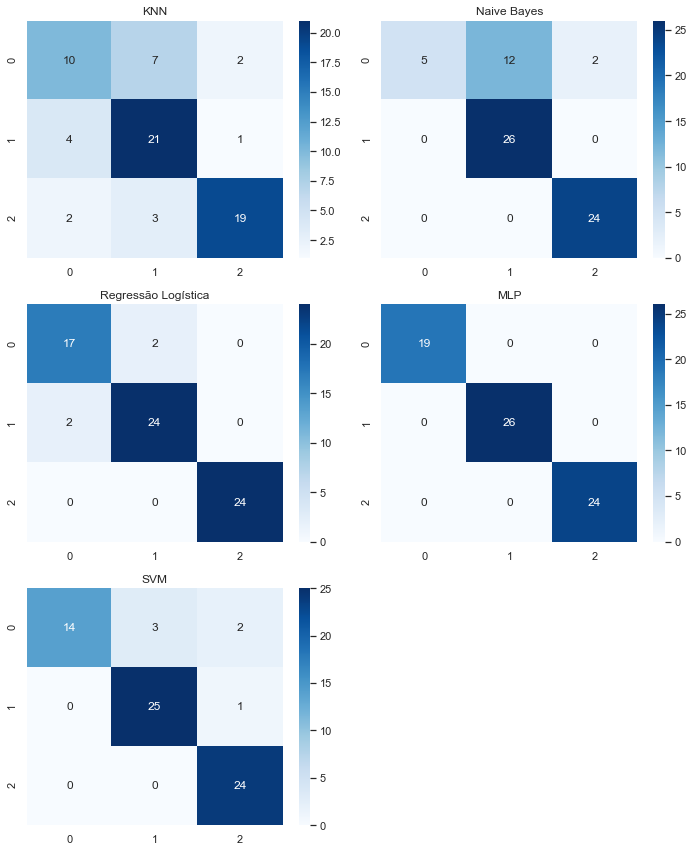

In [25]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Matriz de confusão de cada modelo
# ==========================================================
comparar_modelos_plot_confusao(modelos, X_train, y_train, labels=[0, 1, 2])

In [26]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Classification Reports
# ==========================================================
mostrar_classification_reports(modelos, X_train, y_train)



=== Classification Report: KNN ===
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        19
           1       0.68      0.81      0.74        26
           2       0.86      0.79      0.83        24

    accuracy                           0.72        69
   macro avg       0.72      0.71      0.71        69
weighted avg       0.73      0.72      0.72        69


=== Classification Report: Naive Bayes ===
              precision    recall  f1-score   support

           0       1.00      0.26      0.42        19
           1       0.68      1.00      0.81        26
           2       0.92      1.00      0.96        24

    accuracy                           0.80        69
   macro avg       0.87      0.75      0.73        69
weighted avg       0.85      0.80      0.75        69


=== Classification Report: Regressão Logística ===
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        

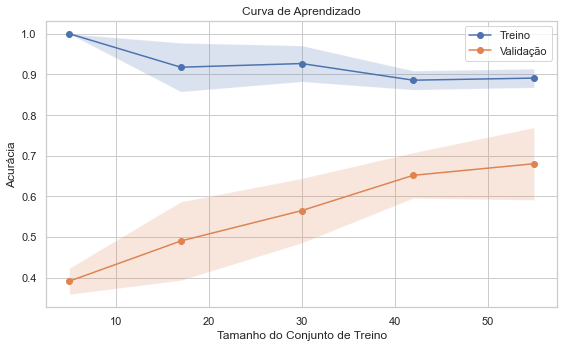

In [27]:
# ==========================================================
# ANÁLISE DOS RESULTADOS - Curva de aprendizado para o melhor modelo
# ==========================================================
plot_learning_curve_model(model_svm, X_train, y_train)


In [28]:
# =========================
# ANÁLISE DOS RESULTADOS - Teste de McNemar (entre dois modelos)
# =========================
pvalor = teste_mcnemar(model_lr, model_svm, X_train, y_train)
pvalor

0.6830913983096086

In [30]:
# ==========================================================
# Gerar submissão para cada modelo
# ==========================================================

gerar_submissao(model_knn, X_test, test_ids, label_encoder, 
                nome_arquivo="submission_knn.csv")

gerar_submissao(model_nb, X_test, test_ids, label_encoder, 
                nome_arquivo="submission_naivebayes.csv")

gerar_submissao(model_lr, X_test, test_ids, label_encoder, 
                nome_arquivo="submission_regressaolog.csv")

gerar_submissao(model_mlp, X_test, test_ids, label_encoder, 
                nome_arquivo="submission_redeneural.csv")

gerar_submissao(model_svm, X_test, test_ids, label_encoder, 
                nome_arquivo="submission_svm.csv")



--- Gerando arquivo de submissão ---

✅ Submissão salva em: dataset/submission_knn.csv

Prévia da submissão:
        Id Predicted_0 Predicted_1 Predicted_2
0  U_19341    0.285714           0    0.714286
1  U_54670    0.142857    0.428571    0.428571
2  U_21920    0.142857    0.142857    0.714286
3  U_58128    0.428571    0.285714    0.285714
4  U_73365    0.428571    0.571429           0

--- Gerando arquivo de submissão ---

✅ Submissão salva em: dataset/submission_naivebayes.csv

Prévia da submissão:
        Id  Predicted_0  Predicted_1  Predicted_2
0  U_19341  1.39424e-14  3.63269e-44            1
1  U_54670  6.92176e-07     0.887593     0.112406
2  U_21920   4.4003e-11  1.53275e-31            1
3  U_58128  6.35672e-05    0.0219222     0.978014
4  U_73365  4.00188e-05      0.99996  2.13003e-07

--- Gerando arquivo de submissão ---

✅ Submissão salva em: dataset/submission_regressaolog.csv

Prévia da submissão:
        Id Predicted_0 Predicted_1 Predicted_2
0  U_19341  0.00149712  0

,Id,Predicted_0,Predicted_1,Predicted_2
0,U_19341,0.116605,0.0377183,0.845677
1,U_54670,0.252713,0.284152,0.463135
2,U_21920,0.106766,0.0453235,0.847911
3,U_58128,0.393381,0.304399,0.302221
4,U_73365,0.396941,0.593343,0.00971605
5,U_89682,0.223543,0.0869643,0.689492
6,U_11501,0.292428,0.337532,0.37004
7,U_46423,0.113316,0.0580531,0.828631
8,U_71408,0.214801,0.113192,0.672007
9,U_95655,0.338732,0.28382,0.377449
